## Data generation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [56]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
num_samples = 1000

# Assign weights to each parameter
parameter_weights = {
    'Body_Temperature_C': 1,
    'Heart_Rate_bpm': 1,
    'BMI': 1,
    'ecg': 1,
    'humidity':.5,
}

# Generate Age: 18 to 80 years
age = np.random.randint(18, 81, size=num_samples)

# Generate Gender: 0 for Male, 1 for Female
gender = np.random.choice(['Male', 'Female'], size=num_samples)

# Generate Weight: 50kg to 120kg, normal distribution centered at 70kg
weight = np.random.normal(loc=70, scale=15, size=num_samples).clip(50, 120).round(1)

# Generate Height: 150cm to 200cm, normal distribution centered at 170cm
height = np.random.normal(loc=170, scale=10, size=num_samples).clip(150, 200).round(1)

# Function to generate vital signs with normal distribution and some outliers
def generate_vital(mean, std, lower, upper, size):
    data = np.random.normal(loc=mean, scale=std, size=size)
    num_outliers = int(0.1 * size)  # Introduce outliers by selecting 10% of data
    outlier_indices = np.random.choice(size, num_outliers, replace=False)
    data[outlier_indices] += np.random.choice([-1, 1], size=num_outliers) * 0.2 * (upper - lower)
    return data.round(1)

# Generate Body Temperature (Normal: 36.1°C to 37.2°C)
body_temp = generate_vital(mean=36.0, std=0.3, lower=35.1, upper=38.0, size=num_samples)

# Generate Heart Rate (Normal: 60-100 bpm)
heart_rate = generate_vital(mean=80, std=10, lower=60, upper=100, size=num_samples)

# Generate humidity (Normal: 30-60 RH)
'''Relative Humidity (RH) is the percentage of water vapor present in the air compared to the maximum amount the air can hold at a given temperature.'''
humidity = generate_vital(mean=45, std=7.5, lower=30,upper=60,size=num_samples)

# Generate ECG (Normal: 275-475, 200-550)
ecg = generate_vital(mean=375, std=87.5, lower=200,upper=550,size=num_samples)

# # Generate HRV (Heart Rate Variability)
# hrv = generate_vital(mean=70, std=15, lower=30, upper=100, size=num_samples)

# # Generate GSR (Galvanic Skin Response)
# gsr = generate_vital(mean=0.2, std=0.1, lower=0.05, upper=0.5, size=num_samples)

# # Generate Oxygen Saturation (Normal: 95-100%)
# oxygen_saturation = generate_vital(mean=98, std=1, lower=95, upper=100, size=num_samples)

# Create DataFrame
data = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Weight_kg': weight,
    'Height_cm': height,
    'Body_Temperature_C': body_temp,
    'Heart_Rate_bpm': heart_rate,
    'Humidity' : humidity,
    'Heart_Electric_Activity' : ecg
#     'HRV_ms': hrv,
#     'GSR_microsiemens': gsr,
#     'Oxygen_Saturation': oxygen_saturation  # Add Oxygen Saturation to DataFrame
})

# Function to calculate BMI
def calculate_bmi(row):
    weight_kg = row['Weight_kg']
    height_m = row['Height_cm'] / 100  # Convert height to meters
    bmi = weight_kg / (height_m ** 2)
    return bmi

# Add BMI to the dataset
data['BMI'] = data.apply(calculate_bmi, axis=1)

# Function to classify BMI categories
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Apply BMI classification
data['BMI_Category'] = data['BMI'].apply(classify_bmi)

# Calculate health score considering parameter weights
def health_score_weighted(row):
    score = 0
    total_weight = 0
    
    if 36.1 <= row['Body_Temperature_C'] <= 37.2:
        score += parameter_weights['Body_Temperature_C']
    total_weight += parameter_weights['Body_Temperature_C']
    
    if 60 <= row['Heart_Rate_bpm'] <= 100:  # Normal range
        score += parameter_weights['Heart_Rate_bpm']
    total_weight += parameter_weights['Heart_Rate_bpm']
    
    if row['BMI_Category'] == 'Normal weight':
        score += parameter_weights['BMI']
    total_weight += parameter_weights['BMI']
    
    if 30<= row['Humidity'] <= 60: 
        score += parameter_weights['humidity']
    total_weight += parameter_weights['humidity']
    
    if 200<=row['Heart_Electric_Activity'] <= 5550: 
        score += parameter_weights['ecg']
    total_weight += parameter_weights['ecg']
    
#     if row['GSR_microsiemens'] <= 0.5:  # Lower GSR indicates low stress
#         score += parameter_weights['GSR_microsiemens']
#     total_weight += parameter_weights['GSR_microsiemens']
    
#     if row['Oxygen_Saturation'] >= 95:  # Normal Oxygen Saturation range
#         score += parameter_weights['Oxygen_Saturation']
#     total_weight += parameter_weights['Oxygen_Saturation']
    
    return score / total_weight if total_weight > 0 else 0

# Apply the weighted health score function
data['Health_Score_Weighted'] = data.apply(health_score_weighted, axis=1)

# Define health status based on the weighted score
def health_status_weighted(score):
    if score >= 0.7:
        return 'Healthy'
    elif 0.4 < score < 0.7:
        return 'Moderate'
    else:
        return 'Critical'

# Apply health status based on the weighted score
data['Health_Status_Weighted'] = data['Health_Score_Weighted'].apply(health_status_weighted)

# encoding
le = LabelEncoder()
#label 
data['Gender'] = le.fit_transform(data['Gender'])  # Male = 1, Female = 0
# onehot
data= pd.get_dummies(data, columns=['BMI_Category'], drop_first=True)


# Apply SMOTE with noise to balance the dataset
def apply_smote_with_noise(data, target_column, noise_factor=0.05):
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Initialize SMOTE with adjusted k_neighbors
    smote = SMOTE(sampling_strategy={'Moderate': int(len(data[data[target_column] == 'Healthy']) ),
                                     'Critical': int(len(data[data[target_column] == 'Healthy']) )},
                  k_neighbors=1, # Setting k_neighbors to 2 to handle small sample sizes
                  random_state=42)
    
    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Add noise to the resampled data
    noise = np.random.normal(0, noise_factor, X_resampled.shape)
    X_resampled_with_noise = X_resampled + noise
    
    # Recombine the features and target
    data_resampled = pd.DataFrame(X_resampled_with_noise, columns=X.columns)
    data_resampled[target_column] = y_resampled
    
    return data_resampled

# Apply SMOTE with noise
df= apply_smote_with_noise(data, target_column='Health_Status_Weighted')



# Display class distribution and the first few rows of the balanced dataset with noise
print(df['Health_Status_Weighted'].value_counts())
print(df.head())


Health_Status_Weighted
Healthy     604
Moderate    604
Critical    604
Name: count, dtype: int64
         Age    Gender  Weight_kg   Height_cm  Body_Temperature_C  \
0  55.961818  0.940775  76.403956  151.256216           36.227932   
1  69.043406  0.981707  73.092535  171.231463           35.816349   
2  45.989832  0.022591  74.179871  168.359339           35.343933   
3  32.031203  0.021849  50.840062  176.730396           35.724253   
4  59.966578 -0.069768  53.832065  172.100067           35.979653   

   Heart_Rate_bpm   Humidity  Heart_Electric_Activity        BMI  \
0       84.601716  57.588538               496.599653  33.448010   
1       49.528164  48.308742               490.109856  24.950152   
2       87.171553  54.268526               543.895617  26.042276   
3       81.205593  33.093456               309.150980  16.270729   
4       85.875456  54.366872               478.590608  18.200497   

   Health_Score_Weighted  BMI_Category_Obese  BMI_Category_Overweight  \
0     

In [57]:
pd.set_option('display.max_columns', None)

In [58]:
pd.reset_option('display.max_columns')  # Reset to default behavior

In [59]:
df.sample(5)

Age    Gender  Weight_kg   Height_cm  Body_Temperature_C  \
955   28.037956  1.010710  73.631516  167.009542           35.959350   
1012  33.979562  1.043075  90.607319  170.356578           35.355927   
720   61.022149  0.013857  52.748191  174.716404           36.435297   
1583  76.985014  0.062349  80.091541  174.377358           35.861375   
64    41.896741  0.050405  91.319349  180.043987           36.363175   

      Heart_Rate_bpm   Humidity  Heart_Electric_Activity        BMI  \
955        83.893207  38.177687               320.456660  26.325853   
1012       83.954604  40.603108               191.886442  31.360182   
720        66.971020  40.895865               402.240462  17.318477   
1583       74.717410  41.370160               328.493393  26.342868   
64         70.323318  48.478047               280.083638  28.227700   

      Health_Score_Weighted  BMI_Category_Obese  BMI_Category_Overweight  \
955                0.564845            0.013068                 1.030422   
1012               0.293109            0.982296                -0.006387   
720                0.779598           -0.007159                 0.004036   
1583               0.533326            0.011267                 0.985274   
64                 0.770288           -0.034819                 0.931724   

      BMI_Category_Underweight Health_Status_Weighted  
955                  -0.002547               Moderate  
1012                  0.016138               Critical  
720                   1.019420                Healthy  
1583                 -0.110529               Moderate  
64                    0.018034                Healthy

In [7]:
data.to_excel('dataset.xlsx', index=False)

In [32]:
data.to_csv('dataset_csv.csv',index=False)

# EDA
### overveiw

In [32]:
print(df.Health_Status_Weighted.value_counts())

Health_Status_Weighted
Moderate    1249
Healthy     1249
Critical    1249
Name: count, dtype: int64


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3747 entries, 0 to 3746
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       3747 non-null   float64
 1   Gender                    3747 non-null   float64
 2   Weight_kg                 3747 non-null   float64
 3   Height_cm                 3747 non-null   float64
 4   Body_Temperature_C        3747 non-null   float64
 5   Heart_Rate_bpm            3747 non-null   float64
 6   Humidity                  3747 non-null   float64
 7   Heart_Electric_Activity   3747 non-null   float64
 8   BMI                       3747 non-null   float64
 9   Health_Score_Weighted     3747 non-null   float64
 10  BMI_Category_Obese        3747 non-null   float64
 11  BMI_Category_Overweight   3747 non-null   float64
 12  BMI_Category_Underweight  3747 non-null   float64
 13  Health_Status_Weighted    3747 non-null   object 
dtypes: float

In [9]:
df.describe()

Age       Gender    Weight_kg    Height_cm  Body_Temperature_C  \
count  5415.000000  5415.000000  5415.000000  5415.000000         5415.000000   
mean     53.373019     0.263480    73.445742   167.971059           36.654313   
std      16.883781     0.444259    12.559108     8.830510            0.409077   
min      17.877509    -0.170173    49.875137   149.864777           35.432020   
25%      39.935862    -0.022013    63.707974   161.445117           36.380497   
50%      57.930044     0.022965    76.212187   166.910482           36.666474   
75%      67.990351     0.918714    81.346402   173.703616           36.943520   
max      80.105341     1.194569   119.965873   199.971187           37.710309   

       Heart_Rate_bpm     Humidity  Heart_Electric_Activity          BMI  \
count     5415.000000  5415.000000              5415.000000  5415.000000   
mean        74.624798    46.646876               361.322291    26.460262   
std         13.778130     7.583080                94.073527     5.570273   
min         40.783818    14.528630                78.512681    13.292145   
25%         58.940024    42.763355               299.280848    21.973471   
50%         75.494874    47.394102               375.800490    27.582597   
75%         84.735959    51.016053               424.436123    30.595259   
max        109.105980    69.793243               705.588710    46.110353   

       Health_Score_Weighted  BMI_Category_Obese  BMI_Category_Overweight  \
count            5415.000000         5415.000000              5415.000000   
mean                0.594615            0.522310                 0.490674   
std                 0.235456            0.502030                 0.502528   
min                 0.159784           -0.223926                -0.180897   
25%                 0.366951            0.002473                -0.001774   
50%                 0.571896            0.911091                 0.102339   
75%                 0.773064            1.002875                 0.997712   
max                 1.142809            1.165129                 1.165683   

       BMI_Category_Underweight  
count               5415.000000  
mean                   0.240782  
std                    0.429578  
min                   -0.186021  
25%                   -0.022156  
50%                    0.021128  
75%                    0.109322  
max                    1.161131

## multivariate analysis

C:\Users\anush\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


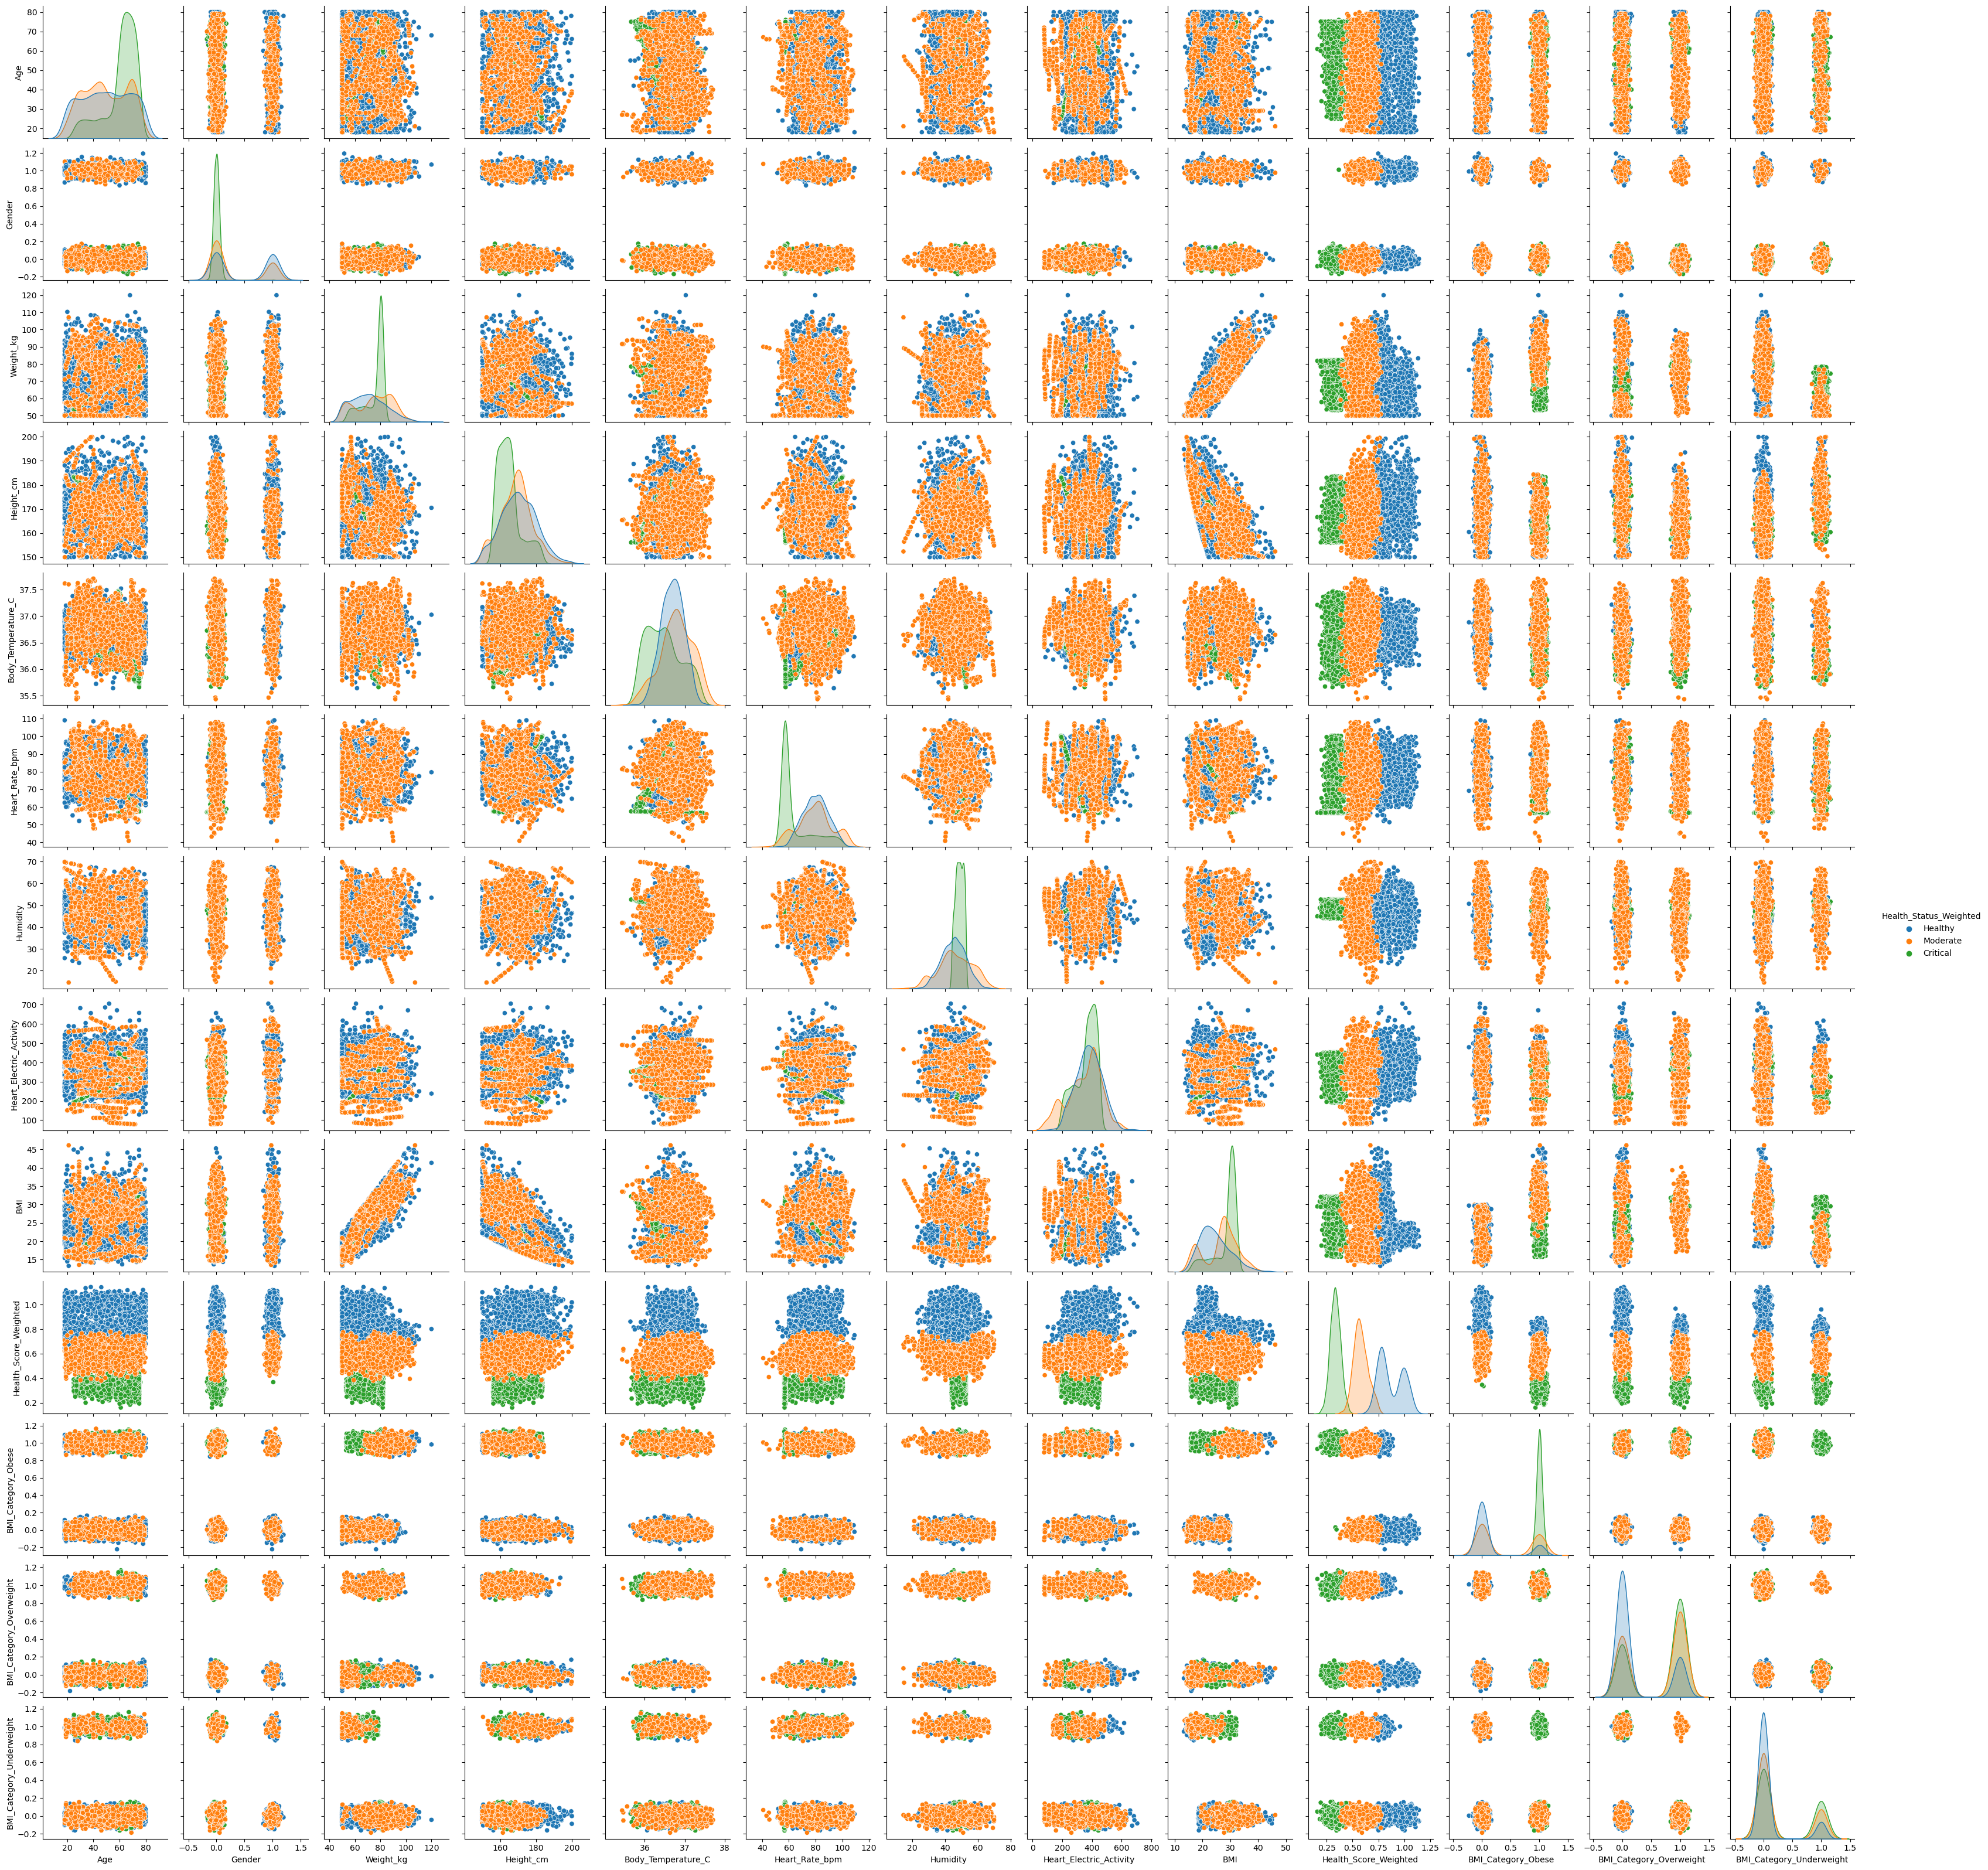

In [11]:
sns.pairplot(df,hue = 'Health_Status_Weighted')
plt.show()

In [9]:
corr=df[[col for col in df.columns if df[col].dtype!='object']].corr()

<Axes: >

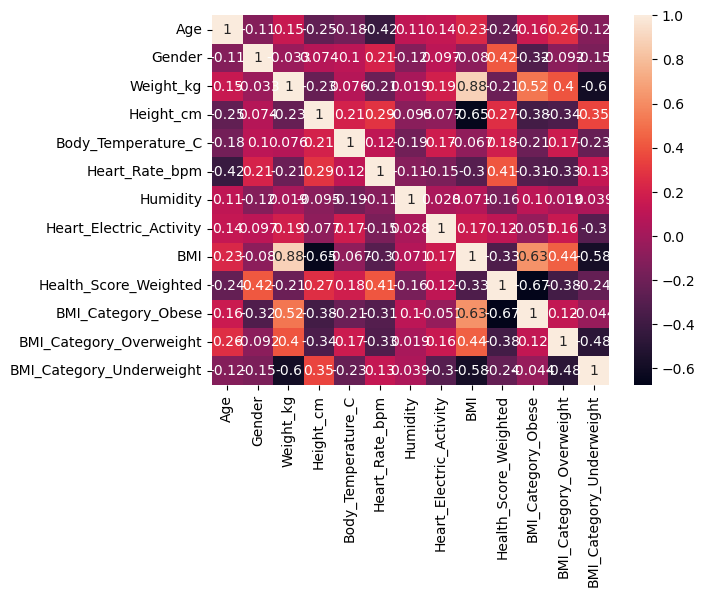

In [12]:
sns.heatmap(corr,annot=True)

In [60]:
# Fit the LabelEncoder
df['Health_Status_Weighted'] = le.fit_transform(df['Health_Status_Weighted'])

# Display the mapping
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Encoding Mapping:")
print(label_mapping)


Label Encoding Mapping:
{'Critical': 0, 'Healthy': 1, 'Moderate': 2}


In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['Age','Gender','Body_Temperature_C','Heart_Rate_bpm','Humidity','Heart_Electric_Activity','BMI']])
column_names=['Age','Gender','Body_Temperature_C','Heart_Rate_bpm','Humidity','Heart_Electric_Activity','BMI']
scaled_df = pd.DataFrame(scaled_df, columns=column_names)
scaled_df=pd.concat([scaled_df,df.Health_Status_Weighted],axis=1)
scaled_df.head()

Age    Gender  Body_Temperature_C  Heart_Rate_bpm  Humidity  \
0  0.450880  0.964255            1.041159        0.168483  1.715224   
1  1.205855  1.046067           -0.192331       -2.239286  0.553756   
2 -0.124631 -0.870947           -1.608134        0.344900  1.299688   
3 -0.930222 -0.872430           -0.468336       -0.064658 -1.350604   
4  0.682006 -1.055548            0.297082        0.255924  1.311998   

   Heart_Electric_Activity       BMI  Health_Status_Weighted  
0                 1.381029  1.319586                       1  
1                 1.318826 -0.230039                       2  
2                 1.834344 -0.030885                       2  
3                -0.415603 -1.812773                       2  
4                 1.208418 -1.460871                       2

In [12]:
scaled_df.to_csv("processed.csv",index=False)

In [62]:
## Train test split
from sklearn.model_selection import train_test_split

# Assuming 'target_column' is the name of the target variable
X = scaled_df.drop('Health_Status_Weighted', axis=1)  # Features
y = scaled_df['Health_Status_Weighted']               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
X_train.shape,y_train.shape

((1449, 7), (1449,))

In [64]:
y_train.unique()

array([0, 2, 1])

In [65]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,roc_curve

In [66]:
## Training
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
y_pred_lr=model.predict(X_test)
# Accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy_lr: {accuracy:.2f}')

# Classification report
print('Classification Report_lr:')
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
print('Confusion Matrix_lr:')
print(confusion_matrix(y_test, y_pred_lr))

#Precision
# Calculates metrics for each label and finds their weighted mean, taking label imbalance into account.
print('Precision_lr:')
print(precision_score(y_test, y_pred_lr,average='weighted'))

# Recall
print('Recall_lr:')
print(recall_score(y_test, y_pred_lr,average='weighted'))
print(f1_score(y_test,y_pred_lr,average='weighted'))

# Roc_auc
fpr1, tpr1, _ = roc_curve(y_test, y_pred_lr)
auc1 = auc(fpr1, tpr1)

# Plot
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_lr[i][:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(8,6))
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (OvR)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Accuracy_lr: 0.66
Classification Report_lr:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       118
           1       0.78      0.78      0.78       130
           2       0.53      0.47      0.50       115

    accuracy                           0.66       363
   macro avg       0.65      0.66      0.66       363
weighted avg       0.66      0.66      0.66       363

Confusion Matrix_lr:
[[ 86   3  29]
 [ 10 101  19]
 [ 36  25  54]]
Precision_lr:
0.6599010648936596
Recall_lr:
0.6639118457300276
0.6606308111058844


ValueError: multiclass format is not supported

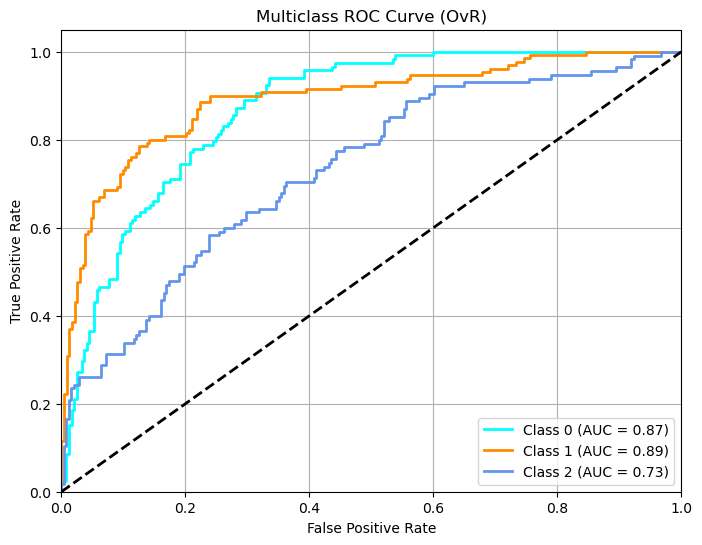

In [67]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: Get the number of classes
classes = np.unique(y)
n_classes = 3

# Step 2: Binarize the output labels
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test)

# Step 3: Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (OvR)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


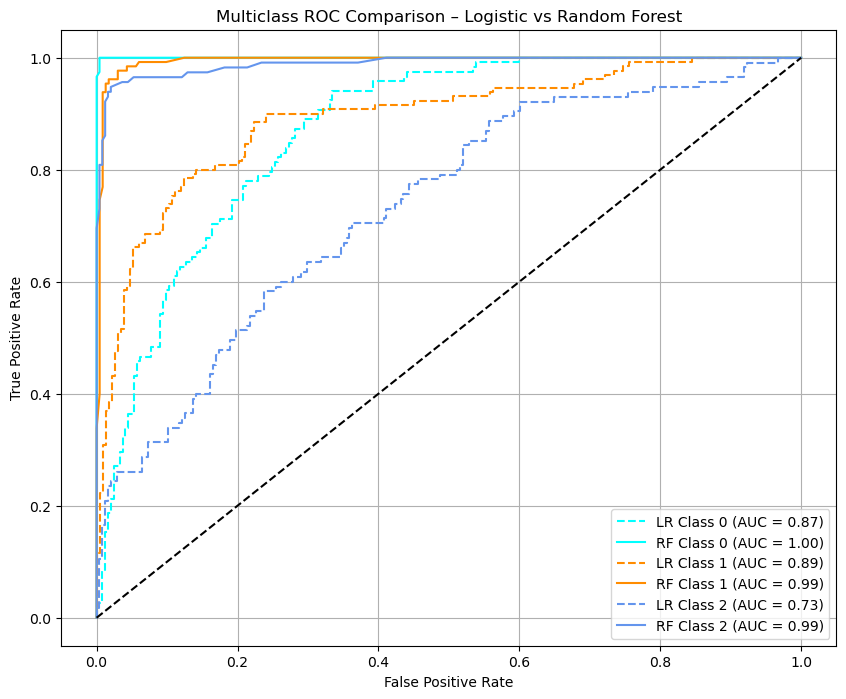

In [68]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Binarize multiclass labels
classes = list(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Train models
lr = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

# Get probabilities
y_score_lr = lr.predict_proba(X_test)
y_score_rf = rf.predict_proba(X_test)

# For ROC curves
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    # Logistic Regression
    fpr[f'lr_{i}'], tpr[f'lr_{i}'], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc[f'lr_{i}'] = auc(fpr[f'lr_{i}'], tpr[f'lr_{i}'])
    plt.plot(fpr[f'lr_{i}'], tpr[f'lr_{i}'], color=color, linestyle='--',
             label=f'LR Class {i} (AUC = {roc_auc[f"lr_{i}"]:.2f})')

    # Random Forest
    fpr[f'rf_{i}'], tpr[f'rf_{i}'], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc[f'rf_{i}'] = auc(fpr[f'rf_{i}'], tpr[f'rf_{i}'])
    plt.plot(fpr[f'rf_{i}'], tpr[f'rf_{i}'], color=color,
             label=f'RF Class {i} (AUC = {roc_auc[f"rf_{i}"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Comparison – Logistic vs Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [70]:
svc = SVC(kernel='sigmoid', gamma=1.0)
# knc = KNeighborsClassifier()
# mnb = MultinomialNB()
# dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2,algorithm='SAMME')
# bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

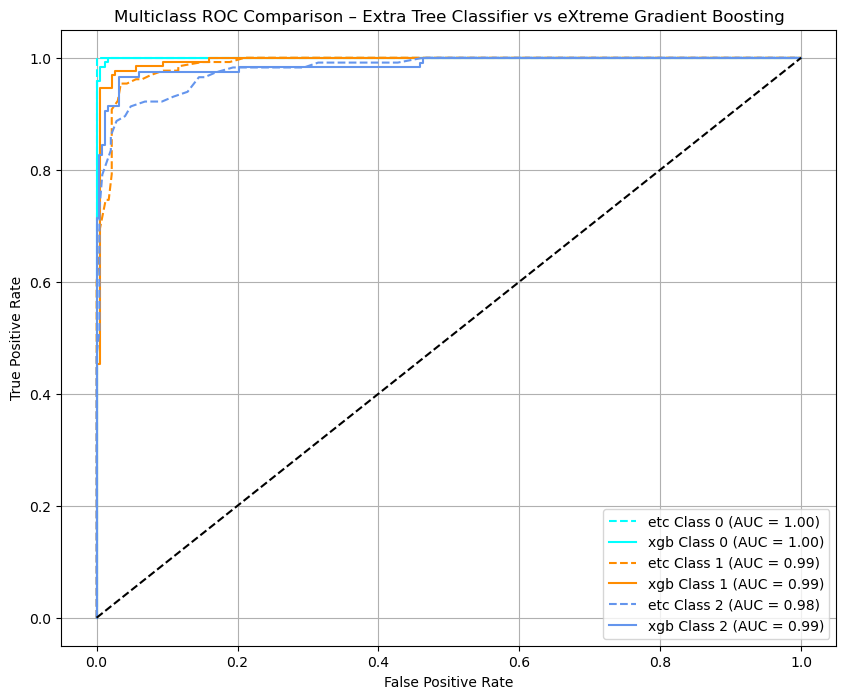

In [71]:
# Binarize multiclass labels
classes = list(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Train models
etc_mm = etc.fit(X_train, y_train)
xgb_mm = xgb.fit(X_train, y_train)

# Get probabilities
y_score_etc = etc_mm.predict_proba(X_test)
y_score_xgb = xgb_mm.predict_proba(X_test)

# For ROC curves
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    # Logistic Regression
    fpr[f'lr_{i}'], tpr[f'lr_{i}'], _ = roc_curve(y_test_bin[:, i], y_score_etc[:, i])
    roc_auc[f'lr_{i}'] = auc(fpr[f'lr_{i}'], tpr[f'lr_{i}'])
    plt.plot(fpr[f'lr_{i}'], tpr[f'lr_{i}'], color=color, linestyle='--',
             label=f'etc Class {i} (AUC = {roc_auc[f"lr_{i}"]:.2f})')

    # Random Forest
    fpr[f'rf_{i}'], tpr[f'rf_{i}'], _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    roc_auc[f'rf_{i}'] = auc(fpr[f'rf_{i}'], tpr[f'rf_{i}'])
    plt.plot(fpr[f'rf_{i}'], tpr[f'rf_{i}'], color=color,
             label=f'xgb Class {i} (AUC = {roc_auc[f"rf_{i}"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Comparison – Extra Tree Classifier vs eXtreme Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [72]:
clfs = {
    'SVC' : svc,
#     'KN' : knc, 
#     'NB': mnb, 
#     'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
#     'BgC': bc, 
    'ETC': etc,
#     'GBDT':gbdt,
    'xgb':xgb
}

In [73]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    classification = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    recall=recall_score(y_test, y_pred,average='weighted')
    F1=f1_score(y_test,y_pred,average='weighted')
    
    # Plotting the confusion matrix
    plt.figure(figsize=(3,2))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
                annot_kws={"size": 8}, linewidths=0.5, linecolor="black")

    # Adding labels and title
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    
    # Adjust xticks and yticks based on your classes
    unique_classes = sorted(set(y_test))
    plt.xticks(ticks=[i + 0.5 for i in range(len(unique_classes))], labels=unique_classes, fontsize=12)
    plt.yticks(ticks=[i + 0.5 for i in range(len(unique_classes))], labels=unique_classes, fontsize=12, rotation=0)

    plt.show()
    
    return accuracy, precision, classification, confusion,recall,F1

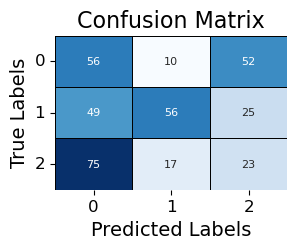

For  SVC
Accuracy :  0.371900826446281
Precision :  0.41562521896585425
Classification report : 
              precision    recall  f1-score   support

           0       0.31      0.47      0.38       118
           1       0.67      0.43      0.53       130
           2       0.23      0.20      0.21       115

    accuracy                           0.37       363
   macro avg       0.41      0.37      0.37       363
weighted avg       0.42      0.37      0.38       363

Confusion Matrix : 
[[56 10 52]
 [49 56 25]
 [75 17 23]]
Recall : 
0.371900826446281
F1 score : 
0.3782657078873785


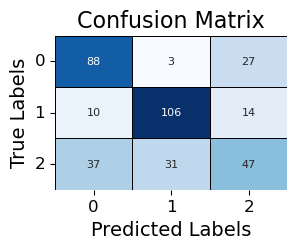

For  LR
Accuracy :  0.6639118457300276
Precision :  0.6522521886846956
Classification report : 
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       118
           1       0.76      0.82      0.79       130
           2       0.53      0.41      0.46       115

    accuracy                           0.66       363
   macro avg       0.65      0.66      0.65       363
weighted avg       0.65      0.66      0.65       363

Confusion Matrix : 
[[ 88   3  27]
 [ 10 106  14]
 [ 37  31  47]]
Recall : 
0.6639118457300276
F1 score : 
0.6540282703110379


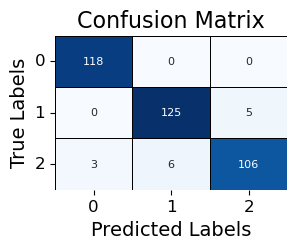

For  RF
Accuracy :  0.9614325068870524
Precision :  0.9612672217956657
Classification report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       118
           1       0.95      0.96      0.96       130
           2       0.95      0.92      0.94       115

    accuracy                           0.96       363
   macro avg       0.96      0.96      0.96       363
weighted avg       0.96      0.96      0.96       363

Confusion Matrix : 
[[118   0   0]
 [  0 125   5]
 [  3   6 106]]
Recall : 
0.9614325068870524
F1 score : 
0.9612011224339062


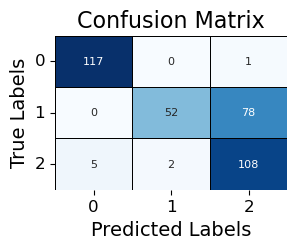

For  AdaBoost
Accuracy :  0.7630853994490359
Precision :  0.8395763964487051
Classification report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       118
           1       0.96      0.40      0.57       130
           2       0.58      0.94      0.72       115

    accuracy                           0.76       363
   macro avg       0.83      0.78      0.75       363
weighted avg       0.84      0.76      0.75       363

Confusion Matrix : 
[[117   0   1]
 [  0  52  78]
 [  5   2 108]]
Recall : 
0.7630853994490359
F1 score : 
0.7459501831920228


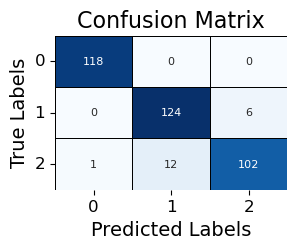

For  ETC
Accuracy :  0.9476584022038568
Precision :  0.9480686673200042
Classification report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       118
           1       0.91      0.95      0.93       130
           2       0.94      0.89      0.91       115

    accuracy                           0.95       363
   macro avg       0.95      0.95      0.95       363
weighted avg       0.95      0.95      0.95       363

Confusion Matrix : 
[[118   0   0]
 [  0 124   6]
 [  1  12 102]]
Recall : 
0.9476584022038568
F1 score : 
0.9474019585273042


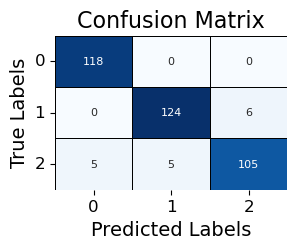

For  xgb
Accuracy :  0.9559228650137741
Precision :  0.9557803750038062
Classification report : 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       118
           1       0.96      0.95      0.96       130
           2       0.95      0.91      0.93       115

    accuracy                           0.96       363
   macro avg       0.96      0.96      0.96       363
weighted avg       0.96      0.96      0.96       363

Confusion Matrix : 
[[118   0   0]
 [  0 124   6]
 [  5   5 105]]
Recall : 
0.9559228650137741
F1 score : 
0.9556171867171557


In [74]:
accuracy_scores = []
precision_scores = []
recall_scores=[]
F1_scores=[]
for name,clf in clfs.items():
    
    current_accuracy,current_precision,classification,confusion,recall,F1= train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy : ",current_accuracy)
    print("Precision : ",current_precision)
    print("Classification report : ")
    print(classification)
    print('Confusion Matrix : ')
    print(confusion)
    print('Recall : ')
    print(recall)
    print('F1 score : ')
    print(F1)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(recall)
    F1_scores.append(F1)

In [75]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'Recall':recall_scores,'F1':F1_scores}).sort_values('Precision',ascending=False)

In [76]:
performance_df

Algorithm  Accuracy  Precision    Recall        F1
2        RF  0.961433   0.961267  0.961433  0.961201
5       xgb  0.955923   0.955780  0.955923  0.955617
4       ETC  0.947658   0.948069  0.947658  0.947402
3  AdaBoost  0.763085   0.839576  0.763085  0.745950
1        LR  0.663912   0.652252  0.663912  0.654028
0       SVC  0.371901   0.415625  0.371901  0.378266

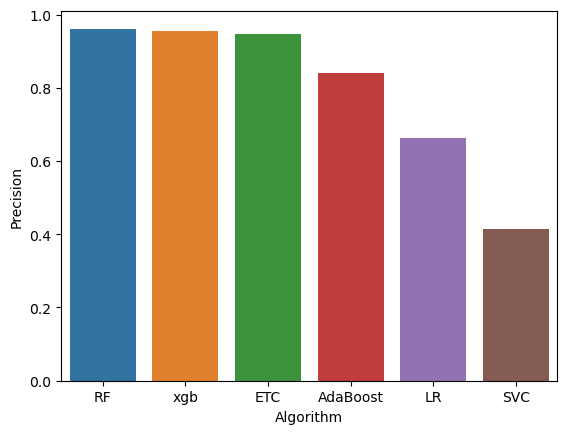

In [77]:
sns.barplot(data=performance_df,x=performance_df.Algorithm,y=performance_df.Accuracy)
sns.barplot(data=performance_df,x=performance_df.Algorithm,y=performance_df.Precision)
plt.show()

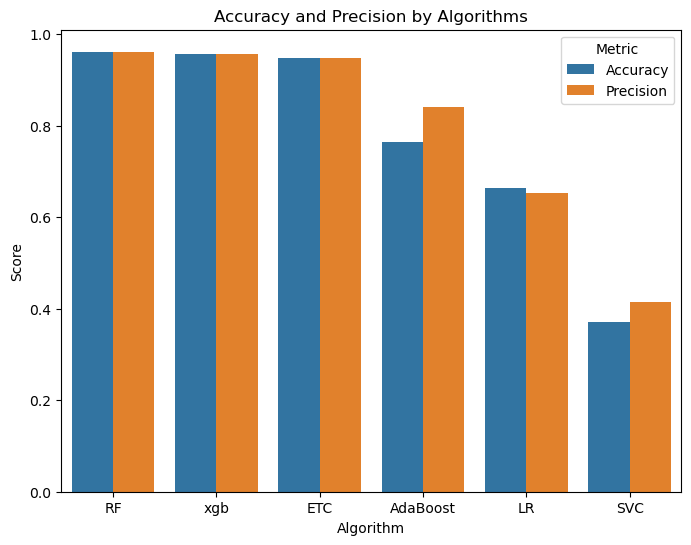

In [78]:
# Melt the data for easier plotting with Seaborn
data_melted = performance_df.melt(id_vars='Algorithm', value_vars=['Accuracy', 'Precision'], var_name='Metric', value_name='Score')

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=data_melted, x='Algorithm', y='Score', hue='Metric')
plt.title("Accuracy and Precision by Algorithms")
plt.show()


In [79]:
df=pd.DataFrame({'Algorithm_Name':['SVC','LogisticRegression','RandomForestClassifier','AdaBoostClassifier','ExtraTreesClassifier','XGBClassifier']})
df=pd.concat([df,performance_df],axis=1)
df=df.sort_values(by='Precision',ascending=False).reset_index(drop=True)

In [80]:
df

Algorithm_Name Algorithm  Accuracy  Precision    Recall        F1
0  RandomForestClassifier        RF  0.961433   0.961267  0.961433  0.961201
1           XGBClassifier       xgb  0.955923   0.955780  0.955923  0.955617
2    ExtraTreesClassifier       ETC  0.947658   0.948069  0.947658  0.947402
3      AdaBoostClassifier  AdaBoost  0.763085   0.839576  0.763085  0.745950
4      LogisticRegression        LR  0.663912   0.652252  0.663912  0.654028
5                     SVC       SVC  0.371901   0.415625  0.371901  0.378266

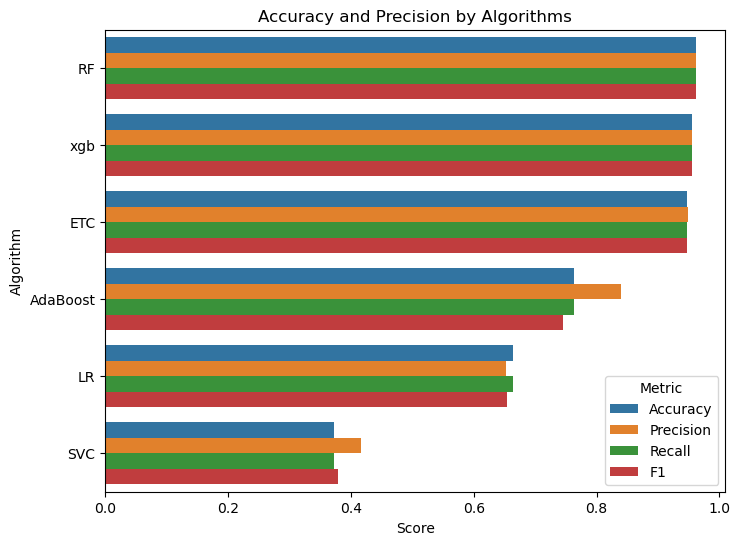

In [81]:
# Melt the data for easier plotting with Seaborn
data_melted = df.melt(id_vars='Algorithm', value_vars=['Accuracy', 'Precision','Recall','F1'], var_name='Metric', value_name='Score')

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=data_melted, x='Score', y='Algorithm', hue='Metric')
plt.title("Accuracy and Precision by Algorithms")
plt.show()
